# Parametric simulation using accim custom models

In [1]:
#todo import qgrid to manually change output dfs

In [1]:
import accim
from accim.parametric_and_optimisation.objectives import return_time_series
from accim.parametric_and_optimisation.utils import make_all_combinations
from besos import eppy_funcs as ef
from matplotlib import pyplot as plt
import seaborn as sns
from accim.utils import print_available_outputs_mod
from accim.parametric_and_optimisation.main import OptimParamSimulation, get_rdd_file_as_df, get_mdd_file_as_df, parse_mtd_file
from os import listdir


ModuleNotFoundError: No module named 'accim.sim.apmv_setpoints'

Let's have a look at the files we currently have in the path:

In [ ]:
original_files = [i for i in listdir()]
original_files

Firstly, the IDF must be read using besos's `get_building` function.

In [ ]:
building = ef.get_building('TestModel.idf')

For this analysis, we want to use the HVAC system in all hours of the year, so that temperature is always comfortable. Therefore, we are going to set the occupancy to always on by means of the function `accim.utils.set_occupancy_to_always`, in which we input the IDF class instance we read in the previous cell.

In [ ]:
accim.utils.set_occupancy_to_always(idf_object=building)

Now, let's start with the settings for the parametric analysis. First, let's instantiate the class `OptimParamSimulation`, and let's pass the IDF instance in the argument `building`. Argument `parameters_type` can take 3 different strings:
- "accim predefined model", in which models are those previously defined in accim (ComfStand=0 to ComfStand=22);
- "accim custom model", in which key parameters of the adaptive comfort model are defined in the relevant arguments;
- "apmv setpoints", in which setpoints are based on the aPMV (Adaptive Predicted Mean Vote) instead of the PMV index;

In this case, we're going to use the 'accim custom model' type, in which we can define the adaptive comfort model.

In [ ]:
parametric = OptimParamSimulation(
    building=building,
    parameters_type='accim custom model',
    #output_type='standard', #
    #output_keep_existing=False, #
    #output_freqs=['hourly'], #
    #ScriptType='vrf_mm', #
    #SupplyAirTempInputMethod='temperature difference', #
    #debugging=True, #
    #verbosemode=False #
)

An initial and generic version of the Adaptive-Comfort-Control-Implementation Script (ACCIS) has been added to the idf instance `building`. For instance, you can take a look at the parameter values accis currently has:

In [ ]:
[i for i in building.idfobjects['energymanagementsystem:program'] if i.Name.lower() == 'setinputdata']

## Setting the outputs

**If you have already read any of the other parametric simulation examples, you can skip this entire outputs section, since it is exactly the same.**

### Outputs for the idf (i.e. the outputs for each simulation run)

First of all, we are going to set the outputs of the simulations that are going to be performed. This is an important step, especially if you are going to run hundreds or thousands of simulations.

Let's take a look at the Output:Variable objects we currently have in the idf. The method `get_output_var_df_from_idf()` returns a pandas DataFrame which contains the information of the existing Output:Variable objects in the idf:

In [ ]:
df_output_variables_idf = parametric.get_output_var_df_from_idf()
df_output_variables_idf

now, let's see the Output:Meter objects:

In [ ]:
df_output_meters_idf = parametric.get_output_meter_df_from_idf()
df_output_meters_idf.head()

In this case, we can see there is no Output:Meter. However, there is a large number of Output:Variable objects which might result in heavy simulation outputs. So, let's get rid of some of them. We can drop the rows we want, and then input the modified DataFrame in the method `set_output_var_df_to_idf(outputs_df)`.

In [ ]:
df_output_variables_idf = df_output_variables_idf[
    (
        df_output_variables_idf['variable_name'].str.contains('Setpoint Temperature_No Tolerance')
        |
        df_output_variables_idf['variable_name'].str.contains('Zone Operative Temperature')
        |
        df_output_variables_idf['variable_name'].str.contains('Zone Thermal Comfort ASHRAE 55 Adaptive Model Running Average Outdoor Air Temperature')
    )
]
df_output_variables_idf

Let's keep only the Output:Variable objects we have filtered using the `set_output_var_df_to_idf(outputs_df)`:

In [ ]:
parametric.set_output_var_df_to_idf(outputs_df=df_output_variables_idf)

We have removed all rows except the adaptive heating and cooling setpoints, the operative temperature and the running mean outdoor temperature. Next optional step is adding Output:Meter objects. We can do that using the method `set_output_met_objects_to_idf(output_meters)`, where `output_meters` is a list of Output:Meter key names.

In [ ]:
output_meters = [
    'Heating:Electricity',
    'Cooling:Electricity',
    'Electricity:HVAC',
]
parametric.set_output_met_objects_to_idf(output_meters=output_meters)

Let's see Output:Meter objects we currently have after adding these:

In [ ]:
df_output_meters_idf = parametric.get_output_meter_df_from_idf()
df_output_meters_idf.head()

### Outputs to be read and shown in the parametric simulation or optimisation

To successfully run the parametric simulation or optimisation, it is advisable running a test simulation to know the outputs that each simulation will have. We can do that with the method `get_outputs_df_from_testsim()`, which returns a tuple containing 2 DataFrames containing respectively the Output:Meter and Output:Variable objects from the simulation. In this case, you won't find wildcards such as "*".

In [ ]:
df_output_meters_testsim, df_output_variables_testsim = parametric.get_outputs_df_from_testsim()

In [ ]:
df_output_meters_testsim

In [ ]:
df_output_variables_testsim

We can get DataFrames from the .rdd and .mdd files generated from the test simulation using the functions `get_rdd_file_as_df()` and `get_mdd_file_as_df()`. 

In [ ]:
df_rdd = get_rdd_file_as_df()
df_rdd

In [ ]:
df_mdd = get_mdd_file_as_df()
df_mdd

Also, we can parse the .mtd files as a list using the function `parse_mtd_file()`.

In [ ]:
mtd_list = parse_mtd_file()
mtd_list[0:2]

Therefore, we have 2 DataFrames, one for the Output:Meter and another for the Output:Variable objects. Next step is setting the outputs for the parametric simulation. To do so, we'll need to pass the DataFrames into the method `set_outputs_for_simulation(df_output_meter, df_output_variable)`. If you have some knowledge about the python package besos, you might think of these dataframes as if each row was a `MeterReader` or `VariableReader` instances respectively for the Output:Meter and Output:Variable dataframes, and the arguments in these were the specified in the columns. The `MeterReader` class takes the arguments `key_name`, `frequency`, `name` and `func`, while `VariableReader` class takes the arguments  `key_value`, `variable_name`, `frequency`, `name` and `func`.

In [ ]:
[i for i in df_output_meters_testsim.columns]

In [ ]:
[i for i in df_output_variables_testsim.columns]

If you take a look at the columns of the dataframes above, you can see the names are the arguments in the `MeterReader` and `VariableReader` classes, and only `name` and `func` are missing. That means, you can add these columns to input the `name` and `func` arguments as desired. In case of the Output:Meter dataframe, we won't add the `name` and `func` columns, which means the name will be the `key_name` and hourly results will be aggregated using the pd.Series.sum() function. However, in case of the Output:Variable dataframe, we will specify these: we want the hourly values rather than the aggregation, therefore we will pass the name bound to the function `return_time_series`, and we will add '_time series' as a suffix to the `variable_name` column. We will also remove the outputs for BLOCK1:ZONE2, which are the rows 2 and 4.

In [ ]:
df_output_variables_testsim['func'] = return_time_series
df_output_variables_testsim['name'] = df_output_variables_testsim['variable_name'] + '_time series'
df_output_variables_testsim = df_output_variables_testsim.drop(index=[2, 4])
df_output_variables_testsim

Finally, let's set the outputs for parametric simulation and optimisation:

In [ ]:
parametric.set_outputs_for_simulation(
    df_output_meter=df_output_meters_testsim,
    df_output_variable=df_output_variables_testsim,
)

If you want to inspect the `VariableReader` and `MeterReader` objects, you can see the internal variable `sim_outputs`:

In [ ]:
parametric.sim_outputs

## Setting the parameters

At the top of the script, when you instantiated the class `OptimParamSimulation`, you already specified which type of parameters you were going to use. Now, the parameters we're about to set, must match the `parameters_type` argument. At this point, you may not know which parameters you can use, so you can call the method `get_available_parameters()`, which will return a list of available parameters:

In [ ]:
available_parameters = parametric.get_available_parameters()
available_parameters

If you don't know what are these, please refer to the [documentation](https://accim.readthedocs.io/en/master/4_detailed%20use.html).

Using the 'accim custom model' type, the values can be either a list of options or a range of values. Now, let's set the parameters using the method `set_parameters(accis_params_dict, additional_params)`. In this method, we set the parameters related to accim using the argument `accis_params_dict`, which takes a dictionary following the pattern {'parameter name': [1, 2, 3, etc]} in case of list of options, or {'parameter name': (min_value, max_value)} in case of the range of values. We can also add some other parameters not related to accim in the argument `additional_params`, which takes a list of parameters as if these were input straight to the besos EPProblem class.

In [43]:
accis_parameters = {
    'CustAST_m': (0.01, 0.99),
    'CustAST_n': (5, 23),
    'CustAST_ASToffset': (2, 4),
    'CustAST_ASTall': (10, 15),
    'CustAST_ASTaul': (30, 35),
}

parametric.set_parameters(accis_params_dict=accis_parameters)

C:\Users\usuario\AppData\Local\Programs\Python\Python39\lib\site-packages\besos\parameters.py:441: UserWarning: This parameter's descriptor is already named CustAST_m.The name used as an input (CustAST_m) will be discarded.
  warnings.warn(
C:\Users\usuario\AppData\Local\Programs\Python\Python39\lib\site-packages\besos\parameters.py:441: UserWarning: This parameter's descriptor is already named CustAST_n.The name used as an input (CustAST_n) will be discarded.
  warnings.warn(
C:\Users\usuario\AppData\Local\Programs\Python\Python39\lib\site-packages\besos\parameters.py:441: UserWarning: This parameter's descriptor is already named CustAST_ASToffset.The name used as an input (CustAST_ASToffset) will be discarded.
  warnings.warn(
C:\Users\usuario\AppData\Local\Programs\Python\Python39\lib\site-packages\besos\parameters.py:441: UserWarning: This parameter's descriptor is already named CustAST_ASTall.The name used as an input (CustAST_ASTall) will be discarded.
  warnings.warn(
C:\Users\u

In [47]:
[i for i in building.idfobjects['EnergyManagementSystem:Program'] if i.Name.lower() == 'setinputdata']

[
 ENERGYMANAGEMENTSYSTEM:PROGRAM,
     SetInputData,             !- Name
     set ComfStand = 99,       !- Program Line 1
     set CAT = 80,             !- Program Line 2
     set ComfMod = 3,          !- Program Line 3
     set HVACmode = 2,         !- Program Line 4
     set VentCtrl = 0,         !- Program Line 5
     set VSToffset = 0,        !- Program Line 6
     set MinOToffset = 50,     !- Program Line 7
     set MaxWindSpeed = 50,    !- Program Line 8
     set ACSTtol = -0.1,       !- Program Line 9
     set AHSTtol = 0.1,        !- Program Line 10
     set CoolSeasonStart = 121,    !- Program Line 11
     set CoolSeasonEnd = 274;    !- Program Line 12]

In [48]:
[i for i in building.idfobjects['EnergyManagementSystem:Program'] if i.Name.lower() == 'applycat']


[
 ENERGYMANAGEMENTSYSTEM:PROGRAM,
     ApplyCAT,                 !- Name
     set CATcoolOffset = 0,    !- Program Line 1
     set CATheatOffset = 0,    !- Program Line 2
     if ComfStand == 99,       !- Program Line 3
     set ACSToffset = 0 + 0,    !- Program Line 4
     set AHSToffset = 0 + 0,    !- Program Line 5
     elseif (ComfStand == 1 ),    !- Program Line 6
     if (CAT == 1),            !- Program Line 7
     set ACSToffset = 2+CATcoolOffset,    !- Program Line 8
     set AHSToffset = -3+CATheatOffset,    !- Program Line 9
     elseif (CAT == 2),        !- Program Line 10
     set ACSToffset = 3+CATcoolOffset,    !- Program Line 11
     set AHSToffset = -4+CATheatOffset,    !- Program Line 12
     elseif (CAT == 3),        !- Program Line 13
     set ACSToffset = 4+CATcoolOffset,    !- Program Line 14
     set AHSToffset = -5+CATheatOffset,    !- Program Line 15
     endif,                    !- Program Line 16
     elseif ComfStand == 2 || ComfStand == 3 || ComfStand == 

In [50]:
[i for i in building.idfobjects['EnergyManagementSystem:Program'] if i.Name.lower() == 'setast']


[
 ENERGYMANAGEMENTSYSTEM:PROGRAM,
     SetAST,                   !- Name
     set SetpointAcc = 10000,    !- Program Line 1
     set m = 0,                !- Program Line 2
     set n = 0,                !- Program Line 3
     if CoolSeasonEnd > CoolSeasonStart,    !- Program Line 4
     if (DayOfYear >= CoolSeasonStart) && (DayOfYear < CoolSeasonEnd),    !- Program Line 5
     set CoolingSeason = 1,    !- Program Line 6
     else,                     !- Program Line 7
     set CoolingSeason = 0,    !- Program Line 8
     endif,                    !- Program Line 9
     elseif CoolSeasonStart > CoolSeasonEnd,    !- Program Line 10
     if (DayOfYear >= CoolSeasonStart) || (DayOfYear < CoolSeasonEnd),    !- Program Line 11
     set CoolingSeason = 1,    !- Program Line 12
     else,                     !- Program Line 13
     set CoolingSeason = 0,    !- Program Line 14
     endif,                    !- Program Line 15
     endif,                    !- Program Line 16
     if (ComfStan

If you want to inspect the `Parameter` objects, you can see the internal variable `parameters_list`:

In [44]:
parametric.parameters_list

[Parameter(selector=GenericSelector(set=<function modify_CustAST_m at 0x0000013FE1E1F4C0>), value_descriptors=[RangeParameter(name='CustAST_m', min=0.01, max=0.99)]),
 Parameter(selector=GenericSelector(set=<function modify_CustAST_n at 0x0000013FE1E1F550>), value_descriptors=[RangeParameter(name='CustAST_n', min=5, max=23)]),
 Parameter(selector=GenericSelector(set=<function modify_CustAST_ASToffset at 0x0000013FE1E1F700>), value_descriptors=[RangeParameter(name='CustAST_ASToffset', min=2, max=4)]),
 Parameter(selector=GenericSelector(set=<function modify_CustAST_ASTall at 0x0000013FE1E1F3A0>), value_descriptors=[RangeParameter(name='CustAST_ASTall', min=10, max=15)]),
 Parameter(selector=GenericSelector(set=<function modify_CustAST_ASTaul at 0x0000013FE1E1F430>), value_descriptors=[RangeParameter(name='CustAST_ASTaul', min=30, max=35)])]

## Running the parametric simulation

### Setting the problem

First, let's set the problem. To do so, use the `set_problem()` method. In case of the parametric simulation you don't need to input any argument. However, in case of the optimisation, you must input the arguments `minimize_outputs`, `constraints` and `constraint_bounds`, similarly as you would do in the besos `EPProblem` class.

In [45]:
parametric.set_problem()

Again, you can inspect the `EPProblem` class instance in the internal variable `problem`:

In [46]:
parametric.problem

EPProblem(inputs=[Parameter(selector=GenericSelector(set=<function modify_CustAST_m at 0x0000013FE1E1F4C0>), value_descriptors=[RangeParameter(name='CustAST_m', min=0.01, max=0.99)]), Parameter(selector=GenericSelector(set=<function modify_CustAST_n at 0x0000013FE1E1F550>), value_descriptors=[RangeParameter(name='CustAST_n', min=5, max=23)]), Parameter(selector=GenericSelector(set=<function modify_CustAST_ASToffset at 0x0000013FE1E1F700>), value_descriptors=[RangeParameter(name='CustAST_ASToffset', min=2, max=4)]), Parameter(selector=GenericSelector(set=<function modify_CustAST_ASTall at 0x0000013FE1E1F3A0>), value_descriptors=[RangeParameter(name='CustAST_ASTall', min=10, max=15)]), Parameter(selector=GenericSelector(set=<function modify_CustAST_ASTaul at 0x0000013FE1E1F430>), value_descriptors=[RangeParameter(name='CustAST_ASTaul', min=30, max=35)])], outputs=[MeterReader(name='Heating:Electricity', class_name='Output:Meter', frequency='Hourly', func=<function sum_values at 0x0000013

### Sampling the simulation runs

The way to inform besos of the variations and permutations it must carry out in the parametric analysis is by means of a DataFrame, which must contain a column per `Parameter`, in which values are specified. There are multiple ways to do this DataFrame. For instance, we could make a dataframe from scratch:

In [30]:
import pandas as pd
param_dict = {
    'CustAST_m': [0.1, 0.6], 
    'CustAST_n': [22, 8], 
    'CustAST_ASToffset': [2.5, 4],
    'CustAST_ASTall': [10, 10],
    'CustAST_ASTaul': [35, 35],
}
input_param_df = pd.DataFrame(data=param_dict)
input_param_df

CustAST_m  CustAST_n  CustAST_ASToffset  CustAST_ASTall  CustAST_ASTaul
0        0.1         22                2.5              10              35
1        0.6          8                4.0              10              35

We could input that df, which would result in 2 simulations. But now, imagine we want to make all possible combinations from the values we just did from scratch. We could use the function `make_all_combinations(parameters_values_dict)`. The argument `parameters_values_dict` must be a dictionary in the format {'parameter name': list_of_values}, such as the previouly defined param_dict, so let's input it. Let's see the possibilities:

In [34]:
all_combinations = make_all_combinations(param_dict)
all_combinations

CustAST_m  CustAST_n  CustAST_ASToffset  CustAST_ASTall  CustAST_ASTaul
0         0.1         22                2.5              10              35
1         0.1         22                2.5              10              35
2         0.1         22                2.5              10              35
3         0.1         22                2.5              10              35
4         0.1         22                4.0              10              35
5         0.1         22                4.0              10              35
6         0.1         22                4.0              10              35
7         0.1         22                4.0              10              35
8         0.1          8                2.5              10              35
9         0.1          8                2.5              10              35
10        0.1          8                2.5              10              35
11        0.1          8                2.5              10              35
12        0.1          8                4.0              10              35
13        0.1          8                4.0              10              35
14        0.1          8                4.0              10              35
15        0.1          8                4.0              10              35
16        0.6         22                2.5              10              35
17        0.6         22                2.5              10              35
18        0.6         22                2.5              10              35
19        0.6         22                2.5              10              35
20        0.6         22                4.0              10              35
21        0.6         22                4.0              10              35
22        0.6         22                4.0              10              35
23        0.6         22                4.0              10              35
24        0.6          8                2.5              10              35
25        0.6          8                2.5              10              35
26        0.6          8                2.5              10              35
27        0.6          8                2.5              10              35
28        0.6          8                4.0              10              35
29        0.6          8                4.0              10              35
30        0.6          8                4.0              10              35
31        0.6          8                4.0              10              35

Also, we can use the sampling functions from besos (`full_factorial` and `lhs`), which have been wrapped in the methods `sampling_full_factorial(level)` and `sampling_lhs(num_samples)`. After calling these, the samples are saved in the internal variable `parameters_values_df`. Let's see some examples:

In [37]:
parametric.sampling_full_factorial(level=2)
parametric.parameters_values_df

CustAST_m  CustAST_n  CustAST_ASToffset  CustAST_ASTall  CustAST_ASTaul
0        0.01        5.0                2.0            10.0            30.0
1        0.50        5.0                2.0            10.0            30.0
2        0.01       14.0                2.0            10.0            30.0
3        0.50       14.0                2.0            10.0            30.0
4        0.01        5.0                3.0            10.0            30.0
5        0.50        5.0                3.0            10.0            30.0
6        0.01       14.0                3.0            10.0            30.0
7        0.50       14.0                3.0            10.0            30.0
8        0.01        5.0                2.0            12.5            30.0
9        0.50        5.0                2.0            12.5            30.0
10       0.01       14.0                2.0            12.5            30.0
11       0.50       14.0                2.0            12.5            30.0
12       0.01        5.0                3.0            12.5            30.0
13       0.50        5.0                3.0            12.5            30.0
14       0.01       14.0                3.0            12.5            30.0
15       0.50       14.0                3.0            12.5            30.0
16       0.01        5.0                2.0            10.0            32.5
17       0.50        5.0                2.0            10.0            32.5
18       0.01       14.0                2.0            10.0            32.5
19       0.50       14.0                2.0            10.0            32.5
20       0.01        5.0                3.0            10.0            32.5
21       0.50        5.0                3.0            10.0            32.5
22       0.01       14.0                3.0            10.0            32.5
23       0.50       14.0                3.0            10.0            32.5
24       0.01        5.0                2.0            12.5            32.5
25       0.50        5.0                2.0            12.5            32.5
26       0.01       14.0                2.0            12.5            32.5
27       0.50       14.0                2.0            12.5            32.5
28       0.01        5.0                3.0            12.5            32.5
29       0.50        5.0                3.0            12.5            32.5
30       0.01       14.0                3.0            12.5            32.5
31       0.50       14.0                3.0            12.5            32.5

In [42]:
parametric.sampling_lhs(num_samples=3)
parametric.parameters_values_df

CustAST_m  CustAST_n  CustAST_ASToffset  CustAST_ASTall  CustAST_ASTaul
0   0.675849  22.521357           2.877950            10.0            35.0
1   0.660137   9.424319           3.956983            10.0            35.0
2   0.028543  11.664064           2.116849            10.0            35.0

In [31]:
parametric.sampling_full_set()

Now, you can see the resulting input parameter dataframe in the internal variable `parameters_values_df`:

In [32]:
parametric.parameters_values_df

ComfStand  CAT  ComfMod
2          2   80        3
3          2   90        3

### Running the simulations

Now, we're ready to run the simulations, by means of the `run_parametric_simulation(epws, out_dir, df, processes)` method. After calling the method, the outputs (a DataFrame) is saved in the internal variable `outputs_param_simulation`. It is based on the use of the `EvaluatorEP` class, `df_apply` method. We want to run the parametric simulations with both Sydney and Seville climate files, therefore the filenames are input in a list in the `epws` argument. The simulation outputs will be saved in a directory named 'notebook_temp_dir'. The values for the parameters will be driven by the internal variable `parameters_values_df`, as input in the `df` argument.

In [33]:
parametric.run_parametric_simulation(
    epws=['Sydney.epw', 'Seville.epw'],
    out_dir='notebook_temp_dir',
    df=parametric.parameters_values_df,
    #processes=6, # The number of CPUs to be used. Default is 2.
    #keep_input=True, # To keep the input values of parameters, as entered in df argument. Default is True.
    #keep_dirs=True # To keep the simulation outputs. Default is True.
)

Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...


Let's take a look at the simulation results

In [34]:
parametric.outputs_param_simulation

index  ComfStand  CAT  ComfMod  Heating:Electricity  Cooling:Electricity  \
0      2          2   80        3         2.593138e+09         1.754898e+10   
1      3          2   90        3         3.639536e+09         3.621666e+10   
2      2          2   80        3         2.062257e+09         3.171532e+10   
3      3          2   90        3         2.297988e+09         4.516874e+10   

   Electricity:HVAC  \
0      2.735351e+10   
1      4.728630e+10   
2      4.054615e+10   
3      5.445162e+10   

  Adaptive Cooling Setpoint Temperature_No Tolerance_time series  \
0  [27.325804398148147, 27.91096527777778, 27.910...               
1  [26.325804398148147, 26.91096527777778, 26.910...               
2  [24.785096064814812, 24.86211527777778, 24.862...               
3  [23.785096064814812, 23.86211527777778, 23.862...               

  Adaptive Heating Setpoint Temperature_No Tolerance_time series  \
0  [20.325804398148147, 20.910965277777777, 20.91...               
1  [21.325804398148147, 21.910965277777777, 21.91...               
2  [17.785096064814812, 17.86211527777778, 17.862...               
3  [18.785096064814812, 18.86211527777778, 18.862...               

              Zone Operative Temperature_time series  \
0  [23.771739074031462, 23.897364637263966, 23.75...   
1  [23.66668667903001, 23.8347876559133, 23.82938...   
2  [21.151988618198942, 21.208271993109328, 20.26...   
3  [22.631374958463137, 20.71719912972282, 20.492...   

  Zone Thermal Comfort ASHRAE 55 Adaptive Model Running Average Outdoor Air Temperature_time series  \
0  [21.325694444444437, 21.325694444444437, 21.32...                                                  
1  [21.325694444444437, 21.325694444444437, 21.32...                                                  
2  [11.490694444444445, 11.490694444444445, 11.49...                                                  
3  [11.490694444444445, 11.490694444444445, 11.49...                                                  

                                          output_dir      epw  
0  notebook_temp_dir\BESOS_Output\3XGJQRLTICGY3K8...   Sydney  
1  notebook_temp_dir\BESOS_Output\KYO6E0BHDFYY3PH...   Sydney  
2  notebook_temp_dir\BESOS_Output\T8OPMW5P338ZFRR...  Seville  
3  notebook_temp_dir\BESOS_Output\43Q9COP1KO2RD5H...  Seville

We can see the columns are the following:

- the parameters, which are:

In [35]:
[i.value_descriptors[0].name for i in parametric.parameters_list]

['ComfStand', 'CAT', 'ComfMod']

- the outputs, which are:

In [36]:
[i.name for i in parametric.sim_outputs]

['Heating:Electricity',
 'Cooling:Electricity',
 'Electricity:HVAC',
 'Adaptive Cooling Setpoint Temperature_No Tolerance_time series',
 'Adaptive Heating Setpoint Temperature_No Tolerance_time series',
 'Zone Operative Temperature_time series',
 'Zone Thermal Comfort ASHRAE 55 Adaptive Model Running Average Outdoor Air Temperature_time series']

- the path to the output files for each simulation, in the column 'out_dir'
- the epw for each simulation, in the column 'epw'

### Visualising the results

#### Aggregated columns

At this point, if you have some knowledge of pandas and some package to plot the data (e.g. matplotlib or seaborn), you can carry out your own analysis and visualization. We're going to do some example below.

<Axes: xlabel='Heating:Electricity', ylabel='Cooling:Electricity'>

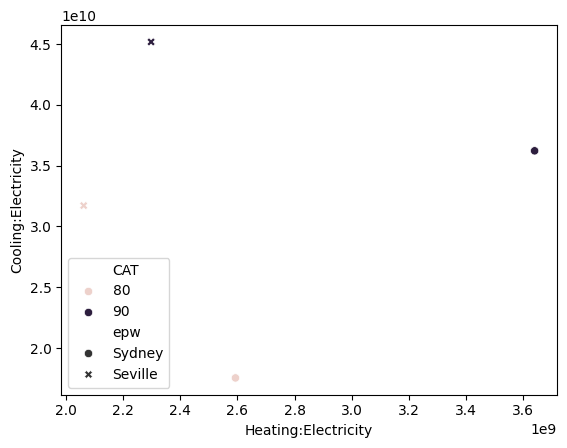

In [37]:
sns.scatterplot(
    data=parametric.outputs_param_simulation,
    x='Heating:Electricity',
    y='Cooling:Electricity',
    hue='CAT',
    style='epw'
)

#### Time series columns

If you requested some output to be reported in time series, you can get a dataframe containing the hourly values using the method `get_hourly_df()`. This dataframe is saved in the internal variable `outputs_param_simulation_hourly`:

In [38]:
parametric.get_hourly_df()
parametric.outputs_param_simulation_hourly

ComfStand  CAT  ComfMod      epw  hour            datetime  \
0              2   80        3   Sydney     1 2024-01-01 01:00:00   
1              2   80        3   Sydney     2 2024-01-01 02:00:00   
2              2   80        3   Sydney     3 2024-01-01 03:00:00   
3              2   80        3   Sydney     4 2024-01-01 04:00:00   
4              2   80        3   Sydney     5 2024-01-01 05:00:00   
...          ...  ...      ...      ...   ...                 ...   
35035          2   90        3  Seville  8756 2024-12-30 20:00:00   
35036          2   90        3  Seville  8757 2024-12-30 21:00:00   
35037          2   90        3  Seville  8758 2024-12-30 22:00:00   
35038          2   90        3  Seville  8759 2024-12-30 23:00:00   
35039          2   90        3  Seville  8760 2024-12-31 00:00:00   

       Adaptive Cooling Setpoint Temperature_No Tolerance_time series  \
0                                              27.325804                
1                                              27.910965                
2                                              27.910965                
3                                              27.910965                
4                                              27.910965                
...                                                  ...                
35035                                          23.933430                
35036                                          23.933430                
35037                                          23.933430                
35038                                          23.933430                
35039                                          23.933430                

       Adaptive Heating Setpoint Temperature_No Tolerance_time series  \
0                                              20.325804                
1                                              20.910965                
2                                              20.910965                
3                                              20.910965                
4                                              20.910965                
...                                                  ...                
35035                                          18.933430                
35036                                          18.933430                
35037                                          18.933430                
35038                                          18.933430                
35039                                          18.933430                

       Zone Operative Temperature_time series  \
0                                   23.771739   
1                                   23.897365   
2                                   23.759499   
3                                   23.810121   
4                                   24.115131   
...                                       ...   
35035                               23.617957   
35036                               23.571012   
35037                               23.340480   
35038                               23.060501   
35039                               22.838352   

       Zone Thermal Comfort ASHRAE 55 Adaptive Model Running Average Outdoor Air Temperature_time series  
0                                              21.325694                                                  
1                                              21.325694                                                  
2                                              21.325694                                                  
3                                              21.325694                                                  
4                                              21.325694                                                  
...                                                  ...                                                  
35035                                          11.720741                              

Let's prepare the `outputs_param_simulation_hourly` df for plotting:

In [39]:
#Let's make a copy of the dataframe to not to modify the original one
df = parametric.outputs_param_simulation_hourly.copy()

# The name of the column for the Running mean outdoor temperature is very long, so let's save it in the variable rmot:
rmot = [i for i in df.columns if 'Running Average' in i][0]

#Let's remove the columns where value is the same for all rows
for c in df.columns:
    if len(set(df[c])) == 1:
        df = df.drop(columns=[c])
#Now let's remove the hour and datetime columns, since will
df = df.drop(columns=['hour'])

# Now let's reshape the df for plotting purposes
df = df.melt(id_vars=['datetime', 'CAT', 'epw', rmot])


Firstly, we're going to plot the hourly temperatures to see the slope of the comfort model, and check all hours are within thermal comfort limits (since we applied adaptive setpoints)

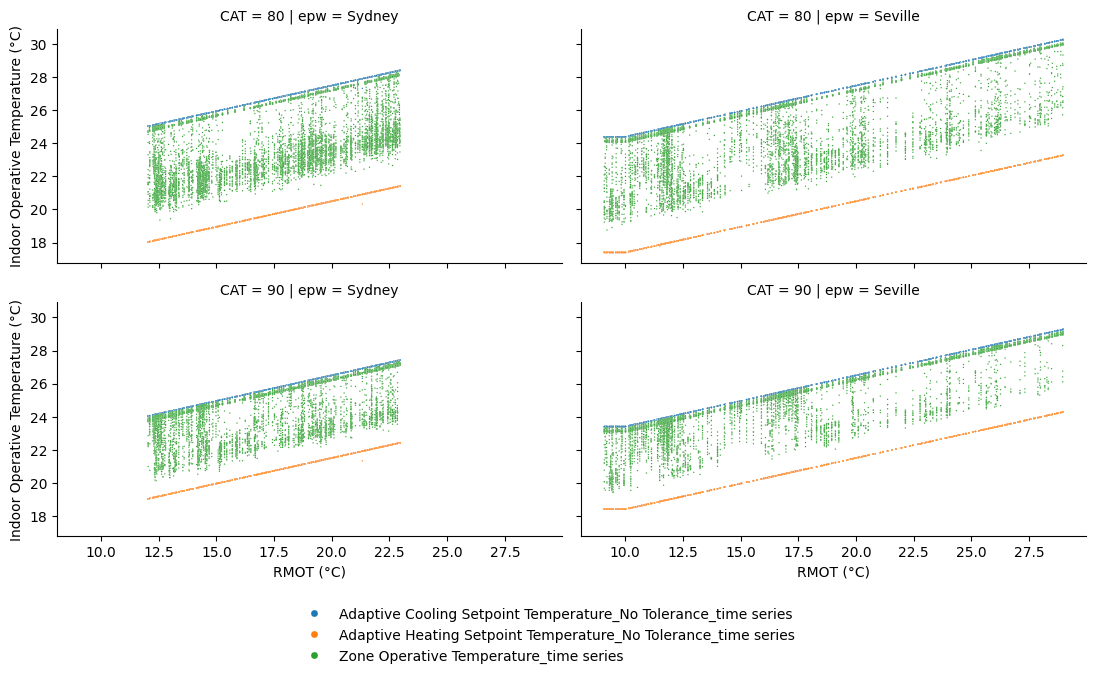

In [45]:
g = sns.FacetGrid(
    data=df,
    row='CAT',
    col='epw'
)
g.map_dataframe(
    sns.scatterplot,
    x=rmot,
    y='value',
    hue='variable',
    s=1,
    #alpha=0.5
)
g.set_axis_labels('RMOT (°C)', 'Indoor Operative Temperature (°C)')
g.add_legend(loc='upper center', bbox_to_anchor=(0.5, 0))

for lh in g._legend.legend_handles:
    lh.set_markersize(5)
plt.tight_layout()


Now, we're going to plot time on x-axis and change the plot type to lineplot, to see the variarion of the indoor operative temperature throughout the year:

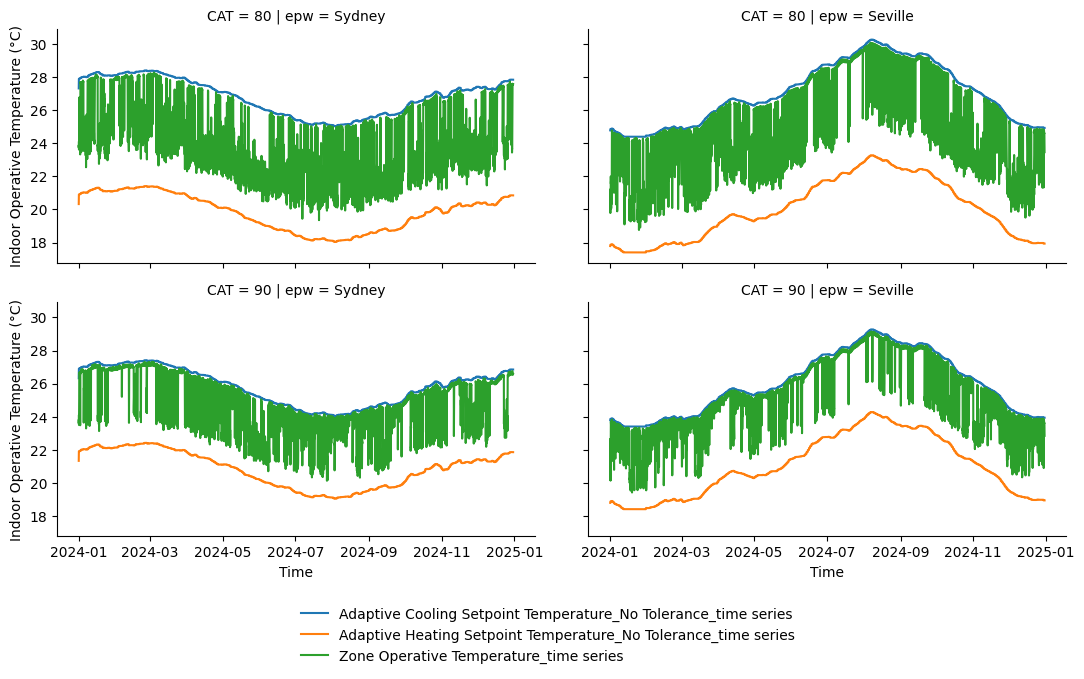

In [44]:
g = sns.FacetGrid(
    data=df,
    row='CAT',
    col='epw'
)
g.map_dataframe(
    sns.lineplot,
    x='datetime',
    y='value',
    hue='variable',
)
g.set_axis_labels('Time', 'Indoor Operative Temperature (°C)')
g.add_legend(loc='upper center', bbox_to_anchor=(0.5, 0))
plt.tight_layout()


We're done with the example, so let's remove all new files, so that we can re-run it again.

In [48]:
current_files = [i for i in listdir()]
new_files = set(current_files) - set(original_files)
new_files

{'available_outputs', 'notebook_temp_dir'}

In [51]:
import os
import shutil
for item in new_files:
    item_path = os.path.join(os.getcwd(), item)
    if os.path.isfile(item_path):
        os.remove(item_path)
    elif os.path.isdir(item_path):
        shutil.rmtree(item_path)